In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import janitor #https://pyjanitor-devs.github.io/pyjanitor/

### Set Global Variables and Create Dataframes

Dataframe Name | Table Name
| --- | --- |
df_epp | Expenditures Per Pupil
df_nxp | Inexperienced Teachers and Principals
df_ocert | Teachers Teaching Out of Certification
df_y | Annual Regents Exams

In [2]:
df_epp = pd.read_excel("../Data/SRC2022/Expenditures Per Pupil.xlsx")
df_nxp = pd.read_excel("../Data/SRC2022/Inexperienced Teachers and Principals.xlsx")
df_ocert = pd.read_excel("../Data/SRC2022/Teachers Teaching Out of Certification.xlsx")
df_y = pd.read_excel("../Data/SRC2022/Annual Regents Exams.xlsx")
df_yy = pd.read_excel("../Data/SRC2022/Accountability Status.xlsx")

Variable Name | Meaning
| --- | --- |
chosen_test_subjects | The Annual Regents Exams we plan to use to measure school performance

In [3]:
df_y.SUBJECT.unique()

array(['Regents Phy Set/Earth Sci', 'Regents Living Environment',
       'Regents Common Core Algebra I',
       'Regents Common Core English Language Art',
       'Regents Phy Set/Physics', 'Regents Common Core Algebra II',
       'Regents Phy Set/Chemistry', 'Regents NF Global History',
       'Regents Common Core Geometry'], dtype=object)

In [4]:
# chosen_test_subjects = ('Regents Common Core Algebra I', 'Regents Common Core English Language Art', 'Regents Phy Set/Earth Sci', 'Regents Common Core Algebra II', 'Regents Common Core Geometry', 'Regents Living Environment')
chosen_test_subjects = ('Regents Phy Set/Earth Sci', 'Regents Living Environment',
       'Regents Common Core Algebra I',
       'Regents Common Core English Language Art',
       'Regents Phy Set/Physics', 'Regents Common Core Algebra II',
       'Regents Phy Set/Chemistry', 'Regents NF Global History',
       'Regents Common Core Geometry')
# chosen_test_subjects = ('Regents Common Core Algebra I',)


### Trimming Dataframes
#### Defining a Trimming Function that will only keep the columns we wish and only keep the rows that have our desired YEAR and SUBGROUP_NAME of "All Students"

In [5]:
def trimmer(df: pd.DataFrame, *column_names, year: int=2022, year_col_name: str="YEAR")->pd.DataFrame:
    """
    Keeps only the columns specified, only the rows whose year agrees with the year argument, 
    and if there is a SUBGROUP column then it keeps only rows with the subgroup classification 
    of "All Students". 
    This is NOT an in-place method. 
    """
    # Trimming Rows
    if year_col_name in df.columns:
        df = df.loc[df[year_col_name]==year]
    if "SUBGROUP_NAME" in df.columns:
        df = df.loc[df["SUBGROUP_NAME"]=="All Students"] #<-----This drops all rows that do not have "All Students" as the "SUBGROUP" column entry. 
    if "SUBJECT" in df.columns:
        df = df.loc[df.SUBJECT.isin(chosen_test_subjects)]
    # Trimming Columns
    return df[list(column_names)]

#### Applying the Trimming Function

In [6]:
# Expenditures Per Pupil: Keep only rows with the year 2021 and keeping only school ID, Name and Normalized Expenditures
df_epp_t = trimmer(df_epp,'ENTITY_NAME', 'ENTITY_CD', 'PER_FED_STATE_LOCAL_EXP')
df_nxp_t = trimmer(df_nxp,'ENTITY_CD', 'PER_TEACH_INEXP')
df_ocert_t = trimmer(df_ocert,'ENTITY_CD', "PER_OUT_CERT")
df_yy_t = trimmer(df_yy, 'INSTITUTION_ID', 'ENTITY_CD', "OVERALL_STATUS")

# df_y: Drop NaN values and make INSTITUTION_ID a string
df_y_c = df_y.dropna(subset=['INSTITUTION_ID'], ignore_index=True)

# df_y: Trim
df_y_t = trimmer(df_y_c.loc[df_y.ENTITY_CD%10000 != 0], 'INSTITUTION_ID', 'ENTITY_CD', 'ENTITY_NAME', 'SUBJECT', "PER_PROF")

We had a lot of trouble with pivoting before. Now, hopefully the code all works well and we can just pivot. 
#### Checking for duplicates. 

In [7]:
df_y_t.ENTITY_CD.value_counts()

ENTITY_CD
30701060000    9
50401040000    9
60601040000    9
31701060000    9
31701060007    9
              ..
60301040004    1
60503040002    1
60800010009    1
70600010021    1
10100010000    1
Name: count, Length: 166, dtype: int64

Success! We have at most 3 instances for each ENTITY_CD, one for each type of exam we decided on. 

But if we look on the row of the last cell, it says "Length: <font color='red'><del>218</del></font> 429". So there are only <font color='red'><del>218</del></font> 429 values. That means there are only <font color='red'><del>218</del></font> 429 schools in the list now. We get the same number when using the INSTITUTION_ID column, so it's not the choice of id:

In [8]:
df_y_t.INSTITUTION_ID.nunique()

166

But if we go back to the original Regents Exams Dataframe, we get almost 3,000 schools. Does this mean that 90% of these didn't have an exam entry for our matching tests? 

In [9]:
df_y.ENTITY_CD.value_counts()

ENTITY_CD
60601040000     214
60601040003     212
62901040000     195
62901040002     195
10100860907     193
               ... 
320900010323      1
320900010328      1
261600010045      1
331700011524      1
342400010113      1
Name: count, Length: 2974, dtype: int64

#### Pivoting the exam results

In [10]:
# It turns out that using lists with single elements was what was keeping the data in the weird form. I had tried .reset_index() a few times and it never worked. This was because I was using the syntax from .pivot_table() instead of .pivot(). Now it works! 
df_y_p = df_y_t.pivot(index='ENTITY_CD', 
                            values="PER_PROF", 
                            columns="SUBJECT"
                            )#.reset_index()
df_y_p.columns.name = None #Gets rid of the "SUBJECT" name for the indices https://www.youtube.com/watch?v=7flWNolPhsc
df_y_p.head()

,Regents Common Core Algebra I,Regents Common Core Algebra II,Regents Common Core English Language Art,Regents Common Core Geometry,Regents Living Environment,Regents NF Global History,Regents Phy Set/Chemistry,Regents Phy Set/Earth Sci,Regents Phy Set/Physics
ENTITY_CD,,,,,,,,,
10100010000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53
10100010030,92,NaN,NaN,s,93,NaN,NaN,NaN,NaN
10100010034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53
10100010045,62,NaN,NaN,100,84,NaN,NaN,NaN,NaN
10100010051,29,NaN,NaN,NaN,67,NaN,NaN,NaN,NaN


And we can see that the table pivots with no trouble, yay! 

In [11]:
df_y_p.head()

,Regents Common Core Algebra I,Regents Common Core Algebra II,Regents Common Core English Language Art,Regents Common Core Geometry,Regents Living Environment,Regents NF Global History,Regents Phy Set/Chemistry,Regents Phy Set/Earth Sci,Regents Phy Set/Physics
ENTITY_CD,,,,,,,,,
10100010000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53
10100010030,92,NaN,NaN,s,93,NaN,NaN,NaN,NaN
10100010034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53
10100010045,62,NaN,NaN,100,84,NaN,NaN,NaN,NaN
10100010051,29,NaN,NaN,NaN,67,NaN,NaN,NaN,NaN


### Merging the Tables
Rather than having 3 different merge functions, we can use the reduce function from the functools library and define one merging function that will merge each cumulative pair of dataframes. 

In [12]:
from functools import reduce

# Data Frames List
data_frames_to_merge = [df_epp_t, df_nxp_t, df_ocert_t, df_yy]

# Merging Function
def merge_function(left_df, right_df):
    return pd.merge(left_df, right_df, on='ENTITY_CD',
                                            how='inner'
                                            )

# Merge 'em! 
df = reduce(merge_function, data_frames_to_merge)

<del>The merge failed because the pivot table has rows/columns at the top that are wonky. We need to look into how to fix that.</del>
The merge was successful! 

In [58]:
df.sample(40)
df.to_csv("../Data/Expendatures Teacher Inexperience Out of Cert and Accountability", index=False)

It now looks like we could turn our attention to the low numbers in the exam columns and find a way to address the "s" characters in them that is preventing them from being numeric. 

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ENTITY_NAME_x            10683 non-null  object 
 1   ENTITY_CD                10683 non-null  int64  
 2   PER_FED_STATE_LOCAL_EXP  10636 non-null  float64
 3   PER_TEACH_INEXP          10571 non-null  float64
 4   PER_OUT_CERT             10514 non-null  float64
 5   INSTITUTION_ID           10683 non-null  int64  
 6   ENTITY_NAME_y            10683 non-null  object 
 7   YEAR                     10683 non-null  int64  
 8   OVERALL_STATUS           10683 non-null  object 
 9   MADE_PROGRESS            309 non-null    object 
 10  OVERRIDE                 281 non-null    object 
 11  MADE_PROGRESS_FLAG       41 non-null     object 
dtypes: float64(3), int64(3), object(6)
memory usage: 1001.7+ KB


In [15]:
df.OVERALL_STATUS.value_counts()

OVERALL_STATUS
Good Standing                                  4669
Local Support and Improvement                  4266
Local Support and Improvement District          605
Comprehensive Support and Improvement           502
Targeted Support and Improvement                302
Target District                                 265
Additional Targeted Support and Improvement      73
CLOSING                                           1
Name: count, dtype: int64

In [ ]:
def status_sorter(status):
    pass

<Axes: xlabel='PER_OUT_CERT', ylabel='PER_TEACH_INEXP'>

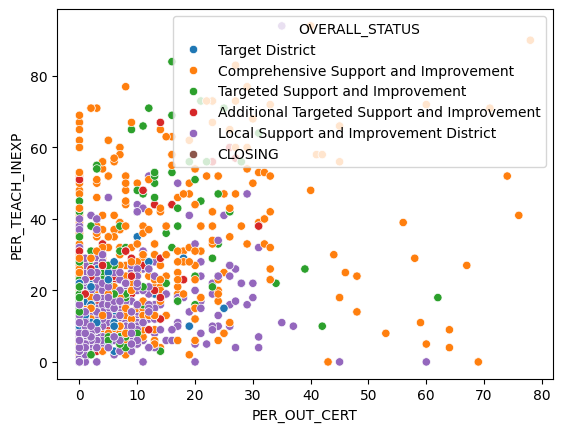

In [56]:
sns.scatterplot(data=df.loc[any()], 
            x="PER_OUT_CERT", 
            y="PER_TEACH_INEXP", 
            hue="OVERALL_STATUS"
            )
# (df['OVERALL_STATUS'] != "Good Standing") & (df['OVERALL_STATUS'] != "Local Support and Improvement")
# df['OVERALL_STATUS'] != "Local Support and Improvement"

In [39]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df.loc[df['Good Standing'] < 1], 
            x="PER_TEACH_INEXP", 
            y="PER_FED_STATE_LOCAL_EXP", 
            hue="OVERALL_STATUS"
            )

KeyError: 'Good Standing'

<Figure size 800x600 with 0 Axes>

count    10443.000000
mean     19533.875227
std       5549.624774
min          0.000000
25%      15459.000000
50%      18816.000000
75%      22684.000000
max      39972.000000
Name: PER_FED_STATE_LOCAL_EXP, dtype: float64

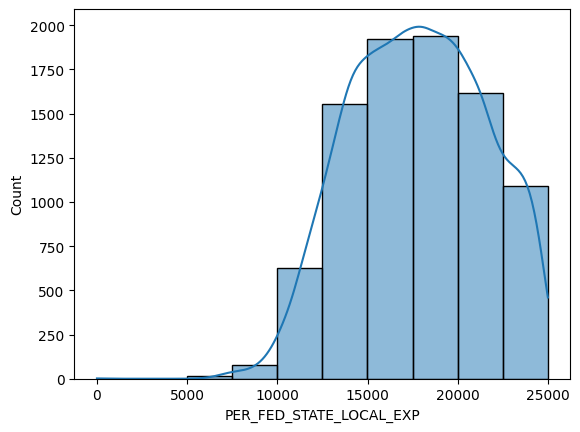

In [49]:
sns.histplot(df.loc[df["PER_FED_STATE_LOCAL_EXP"] < 25000]["PER_FED_STATE_LOCAL_EXP"],
    binwidth=2500,
    kde=True
)
df.loc[df["PER_FED_STATE_LOCAL_EXP"] < 40000]["PER_FED_STATE_LOCAL_EXP"].describe()


In [51]:
df[df["PER_FED_STATE_LOCAL_EXP"] > 10000]["PER_FED_STATE_LOCAL_EXP"].describe()

count    1.054000e+04
mean     2.064362e+04
std      1.819813e+04
min      1.002400e+04
25%      1.559800e+04
50%      1.899850e+04
75%      2.301225e+04
max      1.144732e+06
Name: PER_FED_STATE_LOCAL_EXP, dtype: float64